In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dimod
import dwave_networkx as dnx

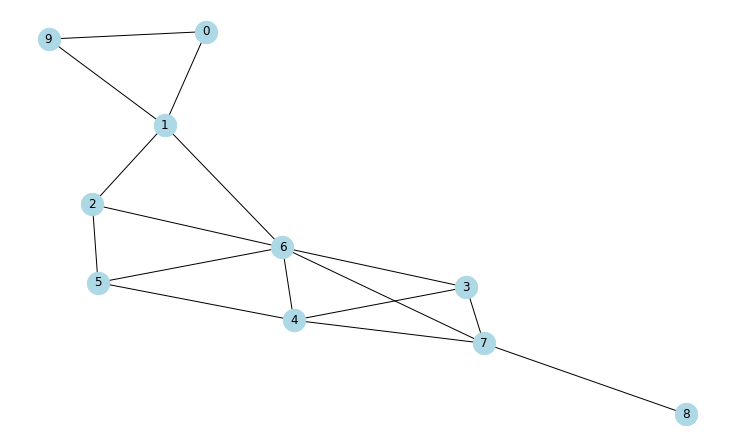

In [2]:
nodes = 2
seed = np.random.randint(1,10)
probability = 10
G = nx.erdos_renyi_graph(10, 0.25, seed=1)

plt.figure(figsize=(10,6))

nx.draw(G, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [3]:
for edge in G.edges:
    G[edge[0]][edge[1]]['length'] = edge[0] + edge[1]

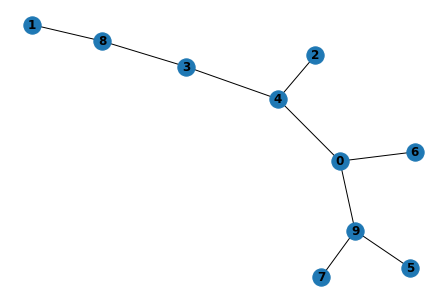

In [4]:
T = nx.random_tree(10, seed=30)
nx.draw(T, with_labels=True, font_weight='bold')

In [5]:
for edge in T.edges:
    T[edge[0]][edge[1]]['length'] = edge[0] + edge[1]

# complete graph & minimum spanning tree

In [6]:
kn = nx.complete_graph(G)

for edge in kn.edges:
#     weight_set.add((edge[0], edge[1], nx.dijkstra_path_length(T, edge[0], edge[1], weight='length')))
    kn[edge[0]][edge[1]]['length'] = nx.dijkstra_path_length(G, edge[0], edge[1], weight='length')

min_spanning_tree = nx.minimum_spanning_tree(kn, weight='length')

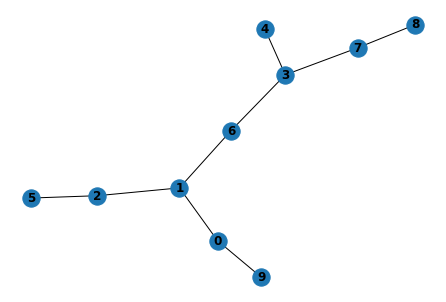

In [7]:
nx.draw(min_spanning_tree, with_labels=True, font_weight='bold')

# minimum cost perfect matching of nodes with odd-degree

In [8]:
odd_degree_nodes = [node for (node, degree) in min_spanning_tree.degree if degree % 2 == 1]
odd_degree_nodes

[1, 3, 4, 5, 8, 9]

In [9]:
nodes_to_remove = list(set(kn.nodes)-set(odd_degree_nodes))
nodes_to_remove

[0, 2, 6, 7]

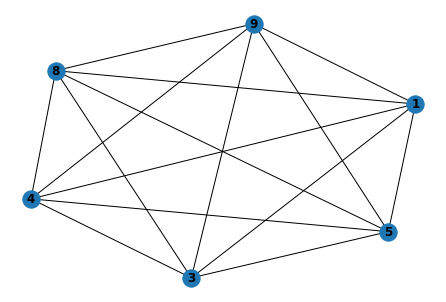

In [10]:
kn_negative = kn.copy()
kn_negative.remove_nodes_from(nodes_to_remove)
nx.draw(kn_negative, with_labels=True, font_weight='bold')

In [11]:
# invert weights
for edge in kn_negative.edges:
    kn_negative[edge[0]][edge[1]]['length'] *= -1

In [12]:
min_cost_perfect_matching = nx.algorithms.matching.max_weight_matching(kn_negative, maxcardinality=True, weight='length')
min_cost_perfect_matching

{(1, 9), (4, 5), (8, 3)}

In [13]:
random_matching = nx.algorithms.maximal_matching(min_spanning_tree)
random_matching

{(0, 1), (2, 5), (3, 4), (7, 8)}

In [14]:
s = 0
for edge in min_cost_perfect_matching:
    s += kn_negative[edge[0]][edge[1]]['length']
s

-44

# graph reconstruction

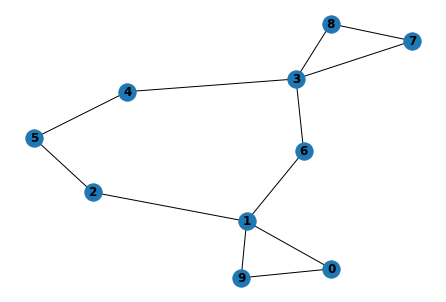

In [15]:
min_spanning_tree_2 = min_spanning_tree.copy()
for edge in min_cost_perfect_matching:
    if not min_spanning_tree.has_edge(edge[0], edge[1]):
        min_spanning_tree.add_edge(edge[0], edge[1], length = kn[edge[0]][edge[1]]['length'])
        min_spanning_tree_2.add_edge(edge[0], edge[1], length = kn[edge[0]][edge[1]]['length'])
    else:
        min_spanning_tree_2.remove_edge(edge[0], edge[1])
        
nx.draw(min_spanning_tree, with_labels=True, font_weight='bold')

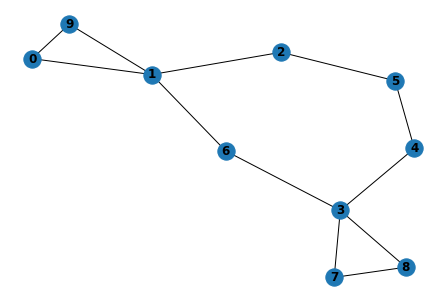

In [16]:
nx.draw(min_spanning_tree_2, with_labels=True, font_weight='bold')

In [17]:
min_spanning_tree_recon = set(min_spanning_tree.to_directed().edges) - set(min_spanning_tree_2.edges)
min_spanning_tree_recon

{(1, 0),
 (2, 1),
 (4, 3),
 (5, 2),
 (5, 4),
 (6, 1),
 (6, 3),
 (7, 3),
 (8, 3),
 (8, 7),
 (9, 0),
 (9, 1)}

# Eulerian walk

In [18]:
# degree of each node in the reconstructed minimum spanning tree

nodes = np.array(np.array(list(min_spanning_tree_recon)).flatten())

unique, counts = np.unique(nodes, return_counts=True)
node_degree = dict(zip(unique, counts))

node_degree

{0: 2, 1: 4, 2: 2, 3: 4, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2}

In [19]:
edge_df = pd.DataFrame(min_spanning_tree_recon, columns=[-1, 1])
edge_df.insert(2, 'visited', False)
edge_df

,-1,1,visited
0,7,3,False
1,9,0,False
2,5,4,False
3,8,3,False
4,9,1,False
5,6,1,False
6,2,1,False
7,6,3,False
8,8,7,False
9,4,3,False


In [20]:
backtracing = []

In [21]:
edge_df = pd.DataFrame(min_spanning_tree_recon, columns=[-1, 1])
edge_df.insert(2, 'visited', False)

def DFS(start_node, df):
    forward_visitation = []
    next_node = np.nan
    current_node = start_node
    forward_visitation.append(start_node)
    while next_node != start_node:
        
        candidate_edges = df[((df[-1] == current_node) | (df[1] == current_node)) & (df['visited'] == False)].index
        selected_edge = np.random.choice(candidate_edges)
        df.loc[selected_edge, 'visited'] = True

        if df.loc[selected_edge, -1] == current_node:
            next_node = df.loc[selected_edge, 1]
        else:
            next_node = df.loc[selected_edge, -1]

        current_node = next_node
        
        forward_visitation.append(current_node)
        
    return(forward_visitation)

DFS(7, edge_df)

[7, 3, 4, 5, 2, 1, 9, 0, 1, 6, 3, 8, 7]

In [23]:
edge_df

,-1,1,visited
0,7,3,True
1,9,0,True
2,5,4,True
3,8,3,True
4,9,1,True
5,6,1,True
6,2,1,True
7,6,3,True
8,8,7,True
9,4,3,True


In [ ]:
def Eulerian_walk(graph_set, source):
    
    df = pd.DataFrame(graph_set, columns=[-1, 1])
    df.insert(2, 'visited', False)
    
    subloops = []
    
    while False in df['visited']:
        subloops.append(DFS(np.random.choice(df.loc[df['visited'] == False, -1].values), df))
    
    return(subloops)

sub_lps = Eulerian_walk(min_spanning_tree_recon, 1)
sub

In [24]:
edge_df = pd.DataFrame(min_spanning_tree_recon, columns=[-1, 1])
edge_df.insert(2, 'visited', False)

subloops = []

while False in edge_df['visited'].values:
    temp = DFS(np.random.choice(edge_df.loc[edge_df['visited']== False, -1].values), edge_df)
    print(temp)

[5, 4, 3, 6, 1, 9, 0, 1, 2, 5]
[8, 7, 3, 8]


In [ ]:
a = np.array(list(min_spanning_tree_recon))
a